In [3]:
from fbprophet.diagnostics import cross_validation
from fbprophet import Prophet
import pandas as pd

In [4]:
df = pd.read_feather(os.path.join('data', 'kaggle-preprocessed', 'aquifer_auser.feather'))
df.index = df.Date
df.head(2)

,Date,rainfall_gallicano,rainfall_pontetetto,rainfall_monte_serra,rainfall_orentano,rainfall_borgo_a_mozzano,rainfall_piaggione,rainfall_calavorno,rainfall_croce_arcana,rainfall_tereglio_coreglia_antelminelli,...,volume_csa,volume_csal,hydrometry_monte_s_quirico,hydrometry_piaggione,year,month,week,day,day_of_year,index_col
Date,,,,,,,,,,,,,,,,,,,,,
1998-03-05,1998-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1998,3,10,5,64,1998-03-05
1998-03-06,1998-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1998,3,10,6,65,1998-03-06


In [5]:
df = df.dropna(subset=['target_depth_to_groundwater_sal'])
rainfall_columns = [col for col in df.columns if 'rainfall' in col]
temperature_columns = [col for col in df.columns if 'temperature' in col]
df['rainfall'] = df[rainfall_columns].sum(axis=1)
df['temperature'] = df[temperature_columns].mean(axis=1)
df.drop(columns=rainfall_columns, inplace=True)
df.drop(columns=temperature_columns, inplace=True)
df['hydrometry_monte_s_quirico'] = df['hydrometry_monte_s_quirico'].interpolate()
df['hydrometry_piaggione'] = df['hydrometry_piaggione'].interpolate()
df.head(2)

,Date,target_depth_to_groundwater_lt2,target_depth_to_groundwater_sal,depth_to_groundwater_pag,depth_to_groundwater_cos,depth_to_groundwater_diec,volume_pol,volume_cc1,volume_cc2,volume_csa,...,hydrometry_monte_s_quirico,hydrometry_piaggione,year,month,week,day,day_of_year,index_col,rainfall,temperature
Date,,,,,,,,,,,,,,,,,,,,,
2007-04-06,2007-04-06,-14.70,-6.69,NaN,-4.68,NaN,-10853.93333,-16859.09333,-13160.80667,0.0,...,0.34,0.24,2007,4,14,6,96,2007-04-06,16.8,12.300
2007-04-07,2007-04-07,-14.71,-6.71,NaN,-4.65,NaN,-10853.93333,-16859.09333,-13160.80667,0.0,...,0.36,0.36,2007,4,14,7,97,2007-04-07,0.0,12.025


In [6]:
features = ['rainfall', 'temperature', 'hydrometry_monte_s_quirico', 'hydrometry_piaggione']
target = ['target_depth_to_groundwater_sal']

train_size = int(0.85 * len(df))
test_size = len(df) - train_size

_df = df[['Date'] + target + features].copy()
_df.columns = ['ds', 'y'] + features

train = _df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(_df.iloc[:train_size, [0, 2, 3, 4, 5]]), pd.DataFrame(_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(_df.iloc[train_size:, [0, 2, 3, 4, 5]]), pd.DataFrame(_df.iloc[train_size:, 1])

In [7]:
model = Prophet()
model.add_regressor('rainfall')
model.add_regressor('temperature')
model.add_regressor('hydrometry_monte_s_quirico')
model.add_regressor('hydrometry_piaggione')
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(model, horizon='30 days')

INFO:fbprophet:Making 237 forecasts with cutoffs between 2008-04-07 00:00:00 and 2018-07-01 00:00:00


KeyboardInterrupt: 

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [150]:
y_pred = model.predict(x_valid)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print('mae: {} rmse: {}'.format(score_mae, score_rmse))

mae: 0.2921144426766965 rmse: 0.6389258814392216


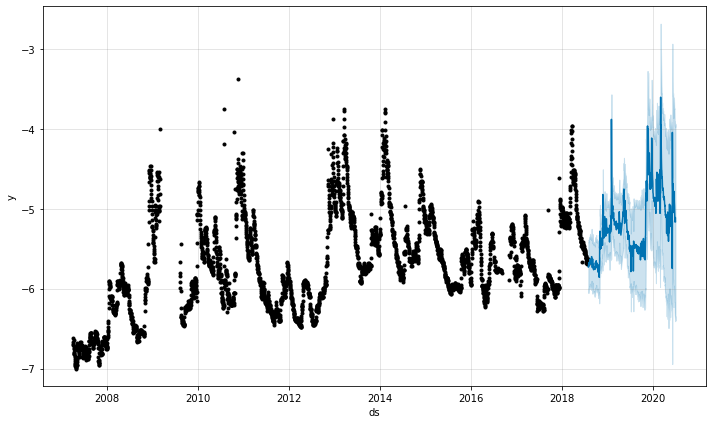

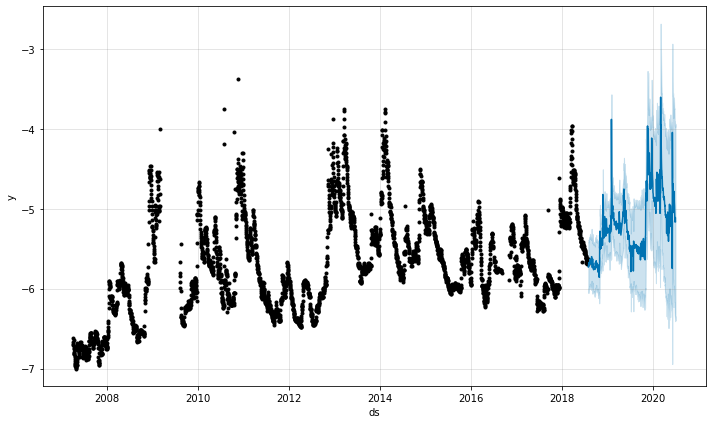

In [151]:
model.plot(y_pred)